In [7]:
%load_ext autoreload
%autoreload 2
import sound_field_creation
from optimizer import optimizer
import utils
from tqdm import tqdm
import numpy as np
import multiprocessing as mp
import math
import time
LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_OPT_METHOD = "GD_lagrange_multi"
SLS_OPT_METHOD = "SLS"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
signals = [
    sound_field_creation.signal_info(
        name="male", signal_path=r"data/sound_files/male_speech.wav", th=90, ph=90,in_rad=False
    ),
    sound_field_creation.signal_info(
        name="female", signal_path=r"data/sound_files/female_speech.wav", th=90, ph=45,in_rad=False
    ),
]

### Encode Sound Field

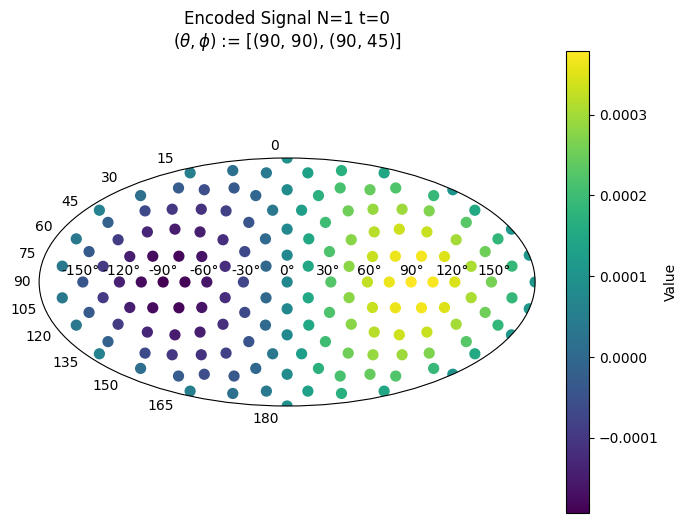

In [9]:
sound_field = sound_field_creation.sound_field()
input_order = 1
anm_t = sound_field.create(
    signals=signals, order=input_order, debug=True, grid_type=POINTS_162
)

### Divide to Subbands

In [35]:
down_sample = 1
num_bins = 1
anm_t_subbands = sound_field.divide_to_subbands(
    num_bins=num_bins, downsample=down_sample
)
print(anm_t_subbands.shape)

(1, 136370, 4)


### Divide to Windows

In [36]:
window_length = 1024 * 2
max_num_windows = 1
anm_t_windowed = sound_field.divide_to_time_windows(
    window_length=window_length, max_num_windows=int(max_num_windows)
)
print(anm_t_windowed.shape)

(1, 1, 1024, 4)


### Create Mask


In [37]:
mask_type = None # "cheat" None , 'algo'

if mask_type is None:
    mask = None
else:
    if mask_type == "cheat":
        target_th = np.array([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = np.array([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = np.logical_or.reduce(np.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(5),axis=1)
    elif mask_type == "algo":
        pass
    dummy = np.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )


### Find Sparse Dict
10 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask : 1139s \
30 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask: 3496a \
10 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  33s \
30 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  70s 

Bands: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, Current Band=0]

29999
Time: 0.927971363067627


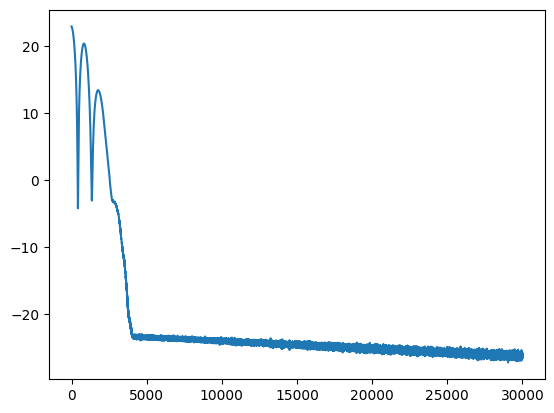

In [38]:
from optimizer import optimizer
import matplotlib.pyplot as plt

Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph)
opt = optimizer(Y_p, alpha=1, method=GD_OPT_METHOD)
start = time.time()
s_dict_subbands = sound_field.get_sparse_dict(opt,mask,multi_processing=False) #single processing progress bar doesnt work
print(f"Time: {time.time()-start}")
s_windowed = np.sum(s_dict_subbands, axis=1)
s_dict = s_windowed.transpose(1, 0, 2).reshape(s_dict_subbands.shape[2], s_dict_subbands.shape[-1] * s_windowed.shape[0])
plt.plot(range(len(sound_field.loss)),sound_field.loss)

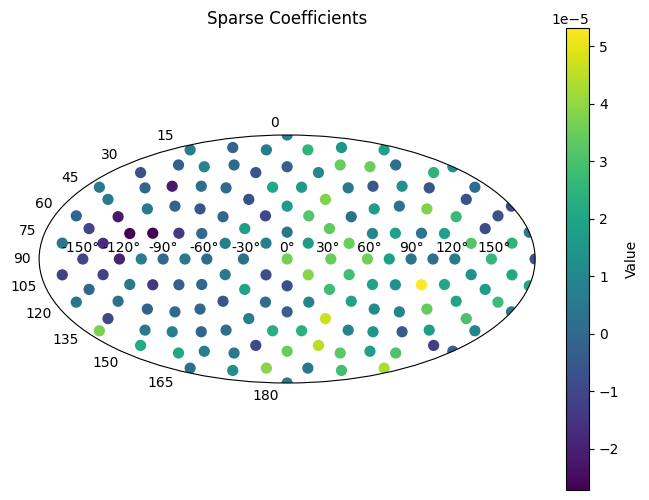

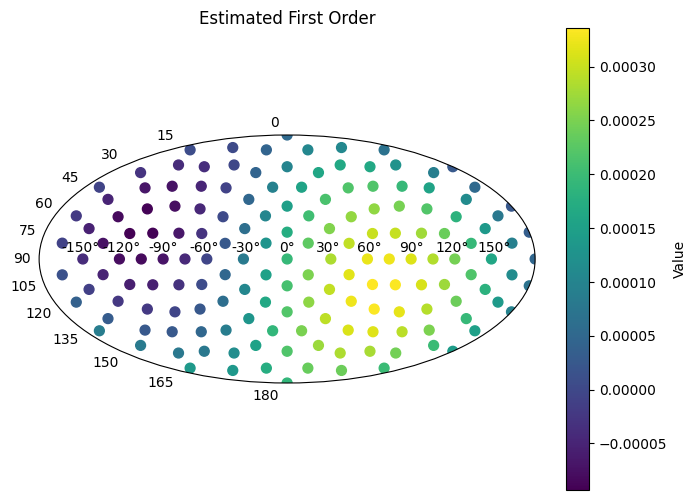

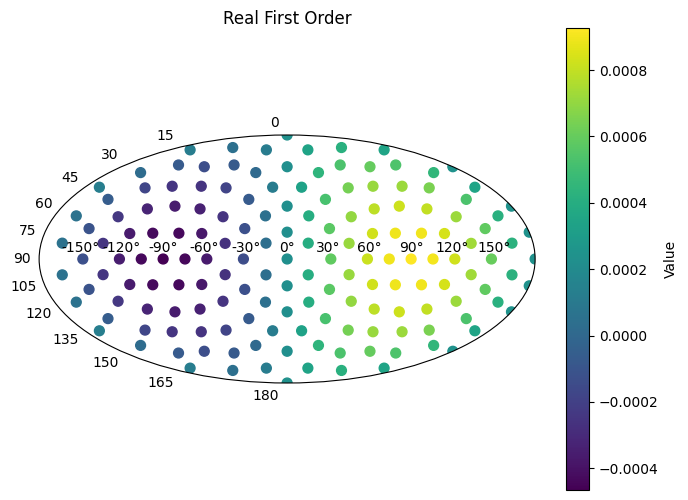

In [39]:
time_index = 300
utils.plot_on_2D(azi=sound_field.P_ph, zen=sound_field.P_th, values=s_dict[:,time_index], title="Sparse Coefficients")
utils.plot_on_2D(azi=sound_field.P_ph, zen=sound_field.P_th, values=Y_p.transpose()@Y_p@s_dict[:,time_index], title="Estimated First Order")
utils.plot_on_2D(azi=sound_field.P_ph, zen=sound_field.P_th, values=Y_p.transpose()@anm_t[time_index,:], title="Real First Order")


